In [20]:
%run ../jupyter/notebook_modules.ipynb

In [ ]:
#import ops.xgboost_dependencies

In [21]:
import subprocess
from datetime import datetime
import pickle
import time

from google.cloud import storage
from google.cloud.exceptions import Conflict
from google.cloud.bigquery.job import ExtractJobConfig
import xgboost as xgb

import bq

importing Jupyter notebook from bq.ipynb
importing Jupyter notebook from competition.ipynb


In [8]:
storage_client = storage.Client()

In [1]:
#BUCKET_NAME = 'natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification'
BUCKET_NAME = 'resonant-goods-241314-lcm'

In [10]:
try:
    bucket = storage_client.create_bucket(BUCKET_NAME)
except Conflict:
    bucket = storage_client.get_bucket(BUCKET_NAME)

In [11]:
dataset_ref = bq.client.dataset(bq.dataset_id)

In [12]:
def export_training_data(table_id):
    table_ref = dataset_ref.table(table_id)
    destination_uri = "gs://{}/{}.csv".format(BUCKET_NAME, table_id)
    job_config = ExtractJobConfig(destination_format="csv", print_header=False)
    extract_job = bq.client.extract_table(
        table_ref,
        destination_uri,
        job_config = job_config
    )
    extract_job.result()  # Waits for job to complete.

    print(
        "Exported {}.{} to {}".format(bq.dataset_id, table_id, destination_uri)
    )

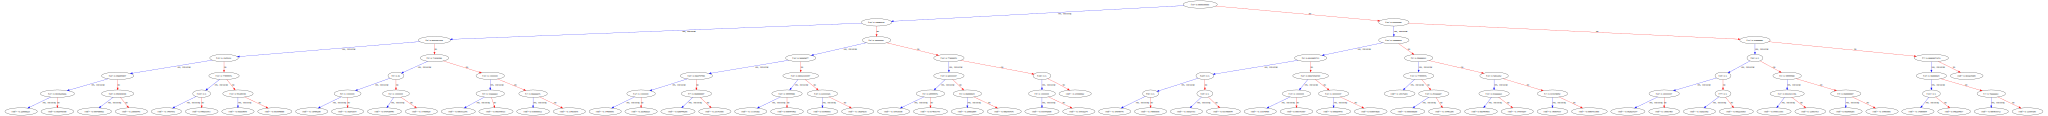

In [29]:
def load_model():
    !gsutil cp gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/model/model.pkl /tmp/model.pkl
    model = pickle.load(open("/tmp/model.pkl", "rb"))
    return model

In [41]:
def xgboost(model_id):
    export_training_data(model_id)
    now = datetime.now().strftime("%Y%m%d%H%M%S")
    job = "{model_id}_{now}".format(model_id=model_id, now=now)
    subprocess.check_output("""\
        gcloud beta ai-platform jobs submit training {job} \
            --master-image-uri=gcr.io/cloud-ml-algos/boosted_trees:latest \
            --scale-tier=BASIC \
            --job-dir=gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification \
            --region=us-central1 \
            -- \
            --preprocess \
            --objective=reg:logistic \
            --training_data_path=gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/{model}.csv
    """.format(job=job, model=model_id), shell=True, stderr=subprocess.STDOUT)
    finished = False
    while not finished:
        time.sleep(60)
        status = !gcloud ai-platform jobs list --filter "jobId:$job" --format="get(STATUS)"
        print(status)
        finished = status[0] in ("SUCCEEDED", "FAILED")
    if status == "FAILED":
        raise Exception("training failed")
    return load_model()

In [32]:
#gsutil cp gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/processed_data/test.csv .

Copying gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/processed_data/test.csv...
| [1 files][325.0 MiB/325.0 MiB]                                                
Operation completed over 1 objects/325.0 MiB.                                    


In [33]:
#dtest = xgb.DMatrix('test.csv?format=csv&label_column=0')

[19:42:19] 360974x288 matrix with 103960512 entries loaded from test.csv?format=csv&label_column=0


In [34]:
#model.eval(dtest)

'[0]\teval-rmse:0.236073'

In [3]:
!gsutil cp gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/train_target_on_identity_and_emotes.csv .

Copying gs://natb1-kaggle-jigsaw-unintended-bias-in-toxicity-classification/train_target_on_identity_and_emotes.csv...
\
Operation completed over 1 objects/77.3 MiB.                                     


In [9]:
#with open("train_target_on_identity_and_emotes.csv") as fd:
#    print(len(fd.readline().split(',')))

30
